In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.search import search
from earthtext.datamodules.components import chipmultilabel
from earthtext.osm import multilabel

from joblib import Parallel, delayed
from importlib import reload
reload(chipmultilabel)
reload(search)

# setup

- copy `s3://clay-text/models/` into `/opt/data/models`
- copy `s3://clay-text/california-worldcover-chips` into `/opt/data/california-worldcover-chips`
- copy `s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/` into `/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips`

double check for the locations on the dataloader configuration below

    metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet
    embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v0.2
    chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips


    !ls /opt/data/models/osm*
    /opt/data/models/osm_emcoder_2024-04-25_12:01.ckpt
    /opt/data/models/osm_emcoder_2024-04-25_12:01.yaml

# load an initialize searcher object

- `search_target` can be `train`, `test` or `val`

In [2]:
reload(search)
# model_ckpt_fname = '/opt/data/models//osm_emcoder__embeddings_v0.2-20240426__trainedon_2024-05-10_02:09.ckpt'
model_ckpt_fname = '/opt/data/models/osm_emcoder__embeddings_v1.0s2__trainedon_2024-05-10_16:22.ckpt'
searcher = search.OSMClayModelSearcher(model_ckpt_fname, search_target='train')

2024-05-21 18:57:51.089 | INFO     | earthtext.search.search:__init__:76 - search target is 'train'


In [3]:
print ("dataloader configuration\n")
for k,v in searcher.conf.dataloader.items():
    print (f"{k:25s} {v}")

dataloader configuration

_target_                  earthtext.datamodules.chipmultilabel.ChipMultilabelModule
metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels_mod-prec70pc_emb-v1s2.parquet
embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v1.0
chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips
get_osm_strlabels         True
get_osm_ohearea           True
get_osm_ohecount          True
get_osm_ohelength         True
embeddings_normalization  True
multilabel_threshold_osm_ohecount 1
osmvector_normalization   True
batch_size                8
num_workers               10


In [4]:
print ("model configuration\n")
for k,v in searcher.conf.model.items():
    print (f"{k:25s} {v}")

model configuration

_target_                  earthtext.models.osmencoder.OSMEncoder
output_dim                768
layers_spec               [512, 1024, 2048]
use_osm_counts            True
use_osm_lengths           True
osm_tags_indexes          [2, 3, 4, 5, 6, 7, 8, 13, 14, 18, 23, 30, 33, 37, 43, 58, 61, 68, 71, 84, 87, 93, 95, 96, 98]
activation_fn             relu


In [5]:
searcher.setup()

2024-05-21 18:57:52.564 | INFO     | earthtext.search.search:setup:115 - loading model
2024-05-21 18:57:52.624 | INFO     | earthtext.search.search:setup:119 - initializing dataloaders
2024-05-21 18:57:53.555 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
2024-05-21 18:57:56.481 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 58598 chip files (out of 58690)
2024-05-21 18:57:56.482 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-21 18:57:56.850 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:104 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-05-21 18:57:57.456 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - re

In [6]:
searcher.model.osm_tags_names

array(['building=*', 'building=apartments', 'building=house',
       'building=industrial', 'building=residential', 'building=school',
       'building=warehouse', 'highway=*', 'highway=track',
       'landuse=commercial', 'landuse=grass', 'landuse=residential',
       'leisure=*', 'leisure=park', 'natural=*', 'natural=water',
       'parking=*', 'sport=*', 'sport=baseball', 'water=*', 'water=lake',
       'waterway=*', 'highway=motorway', 'highway=residential',
       'waterway=stream'], dtype='<U20')

# build the object for autocompletion

it's ok if you get and error like `AssertionError: can only test a child process`, it seems torch dataloaders take care of it

In [11]:
autocompletion_sampler = search.QueryAutocompletionSampler(osm_codeset='sentinel2', searcher=searcher, query_source='train')

2024-05-21 19:00:03.514 | INFO     | earthtext.search.search:__init__:159 - search target is train, query source is train
2024-05-21 19:00:03.515 | INFO     | earthtext.search.search:__init__:163 - loading all samples from query source
100% (7325 of 7325) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000


In [13]:
def get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples, query_min_counts=None, query_min_area_pct=None, n_search_samples=10, max_topn=50):

    if (query_min_area_pct is not None) + (query_min_counts is not None) != 1:
        raise ValueError(f"must set exactly one of 'query_min_area_pct' and 'query_min_counts'")
    
    chipm2 = 256*256*100 # how many square meters in a chip
    rset = []
    precs_at_topn = []

    # make user query vector
    tag_index_for_metric = np.argwhere(searcher.model.osm_tags_names==tag_name_for_metric)[0,0]
    min_counts, max_counts = {tag_name_for_metric: query_min_counts} if query_min_counts is not None else {}, {}
    min_areas,  max_areas  = {tag_name_for_metric: query_min_area_pct*chipm2} if query_min_area_pct is not None else {}  ,{}
        
    for _ in range(n_search_samples):
        
        # average autocomplete
        q = autocompletion_sampler.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                               min_areas = min_areas, max_areas = max_areas,
                                               n_samples=n_autocomplete_samples)
        
        query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    
        # predict embeddings
        p = searcher.predict_embeddings(query_osmvector)[0]
        
        # search
        r = searcher.make_search(p, topn=None)
        rset.append(r)
    
        # measure precision at topn, with n = 1..max_topn
        prec_at_topn = {k: (r['original_osm_vectors']['osm_ohecount'][:, searcher.model.osm_tags_indexes][:, tag_index_for_metric][:k]>1).mean()\
                        for k in range(1,max_topn+1)}
        precs_at_topn.append(prec_at_topn)
    return precs_at_topn
    

In [14]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples=10, query_min_area_pct=.01, n_search_samples=5, max_topn=50)
                                    for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}
    

 88% (22 of 25) |#####################   | Elapsed Time: 0:01:02 ETA:   0:00:08/tmp/ipykernel_12170/4191269555.py:22: RuntimeWarning: Mean of empty slice.
  query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100% (25 of 25) |########################| Elapsed Time: 0:01:10 Time:  0:01:1002


In [15]:
for i in pr.keys():
    k = pd.DataFrame(pr[i])  
    break
k

1    2    3    4    5    6    7    8    9    10  ...        41        42  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.951220  0.928571   
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.951220  0.952381   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.926829  0.928571   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.951220  0.952381   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.951220  0.952381   

         43        44        45        46        47        48        49    50  
0  0.930233  0.931818  0.933333  0.934783  0.936170  0.937500  0.938776  0.94  
1  0.953488  0.954545  0.955556  0.956522  0.957447  0.958333  0.959184  0.96  
2  0.930233  0.931818  0.933333  0.934783  0.936170  0.937500  0.938776  0.94  
3  0.953488  0.954545  0.955556  0.934783  0.936170  0.937500  0.938776  0.94  
4  0.953488  0.954545  0.955556  0.956522  0.957447  0.958333  0.959184  0.96  

[5 rows x 50 columns]

In [16]:
class_prec_means = {i: pd.DataFrame(pr[i]).mean(axis=1).mean() for i in pr.keys()}
class_prec_stds  = {i: pd.DataFrame(pr[i]).mean(axis=1).std() for i in pr.keys()}

Text(0, 0.5, 'precision')

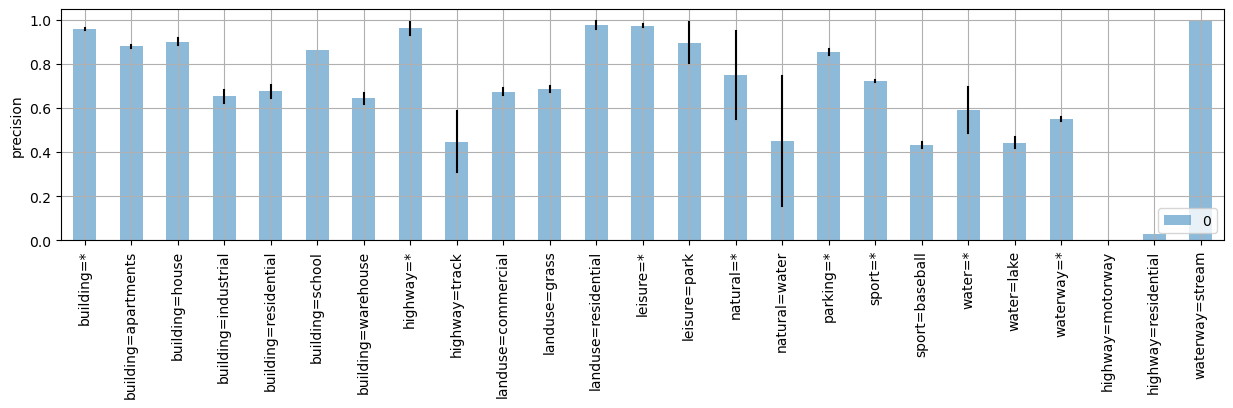

In [17]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")

Text(0, 0.5, 'precision')

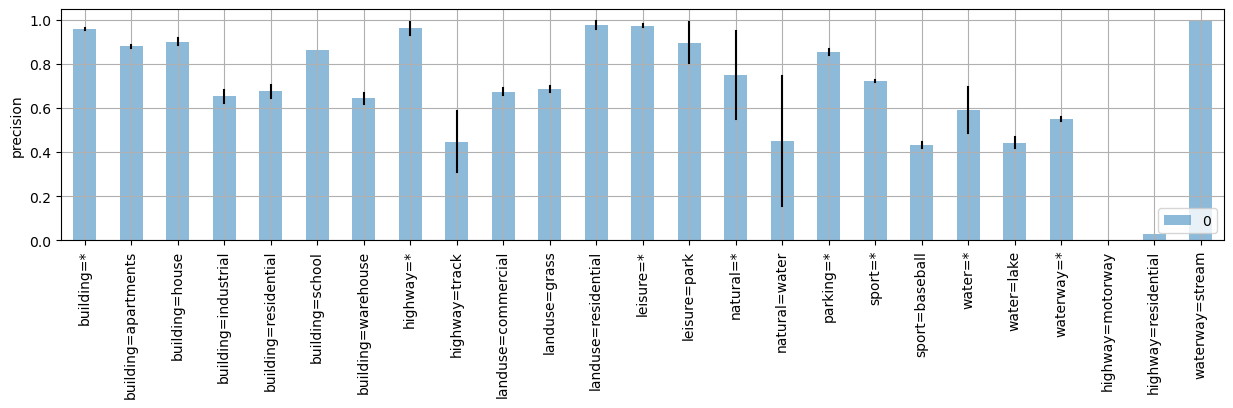

In [18]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")

Text(0, 0.5, 'precision')

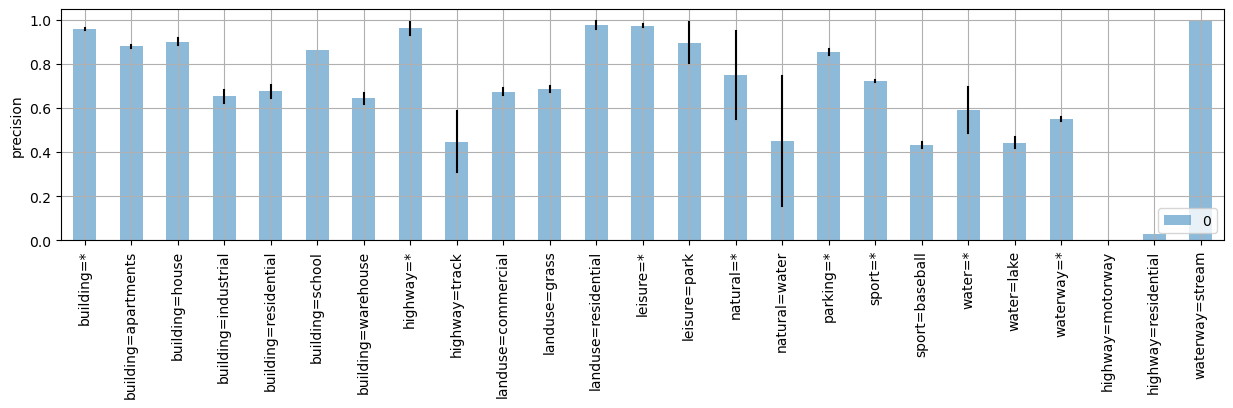

In [19]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(15,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")

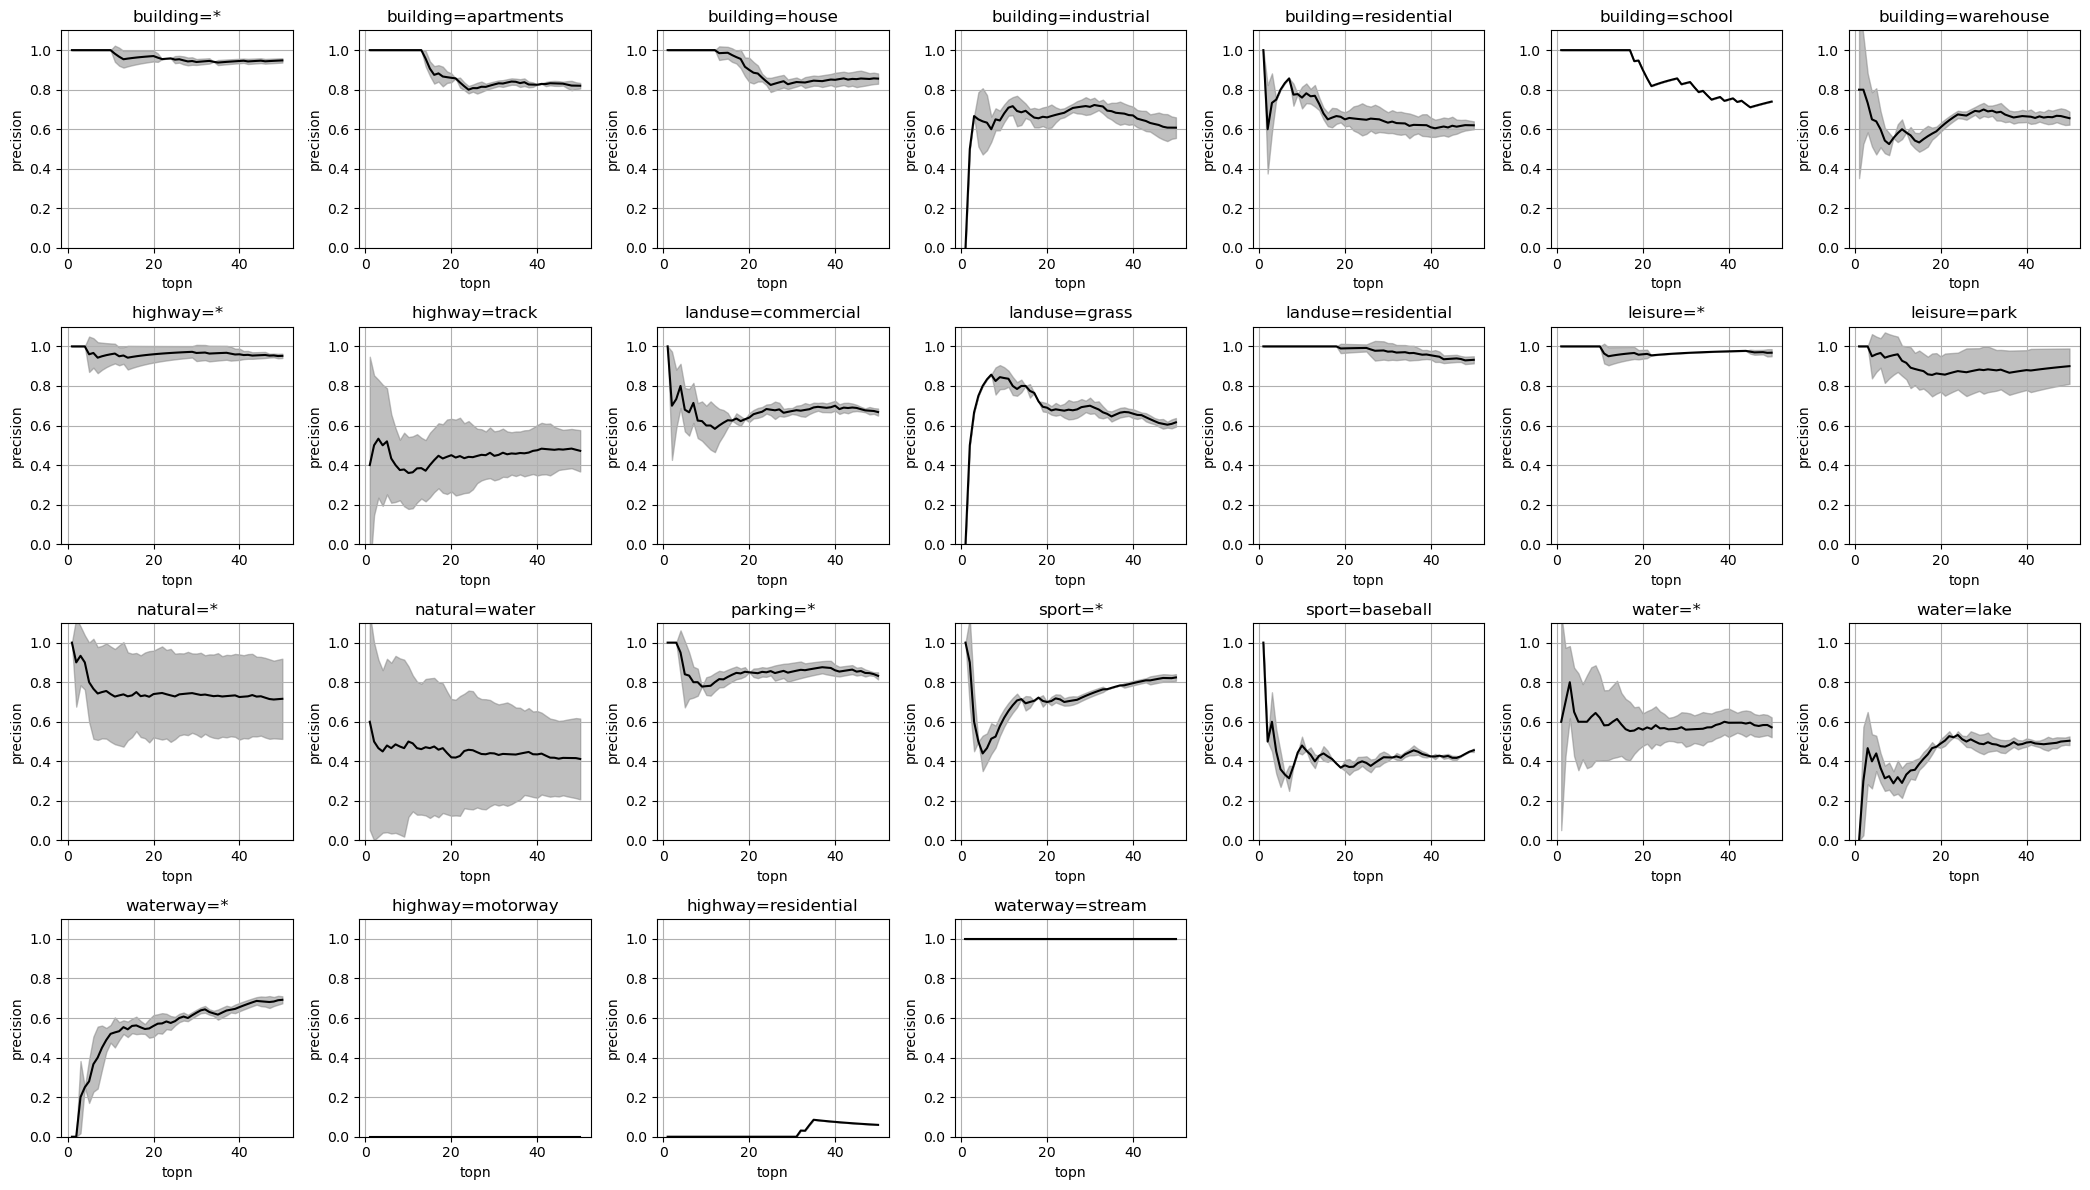

In [20]:
for ax, i in subplots(list(pr.keys()), n_cols=7):
    k = pd.DataFrame(pr[i])  
    pmeans = k.mean(axis=0).values
    pstds  = k.std(axis=0).values

    plt.plot(k.columns, pmeans, color="black")
    plt.fill_between(k.columns, pmeans-pstds, pmeans+pstds, color="gray", alpha=.5)
    plt.grid();
    plt.title(i)
    plt.ylim(0,1.1)
    plt.ylabel("precision")
    plt.xlabel("topn")

In [21]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples=10, query_min_counts=1, n_search_samples=10, max_topn=50)
                                    for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}


100% (25 of 25) |########################| Elapsed Time: 0:02:19 Time:  0:02:190516


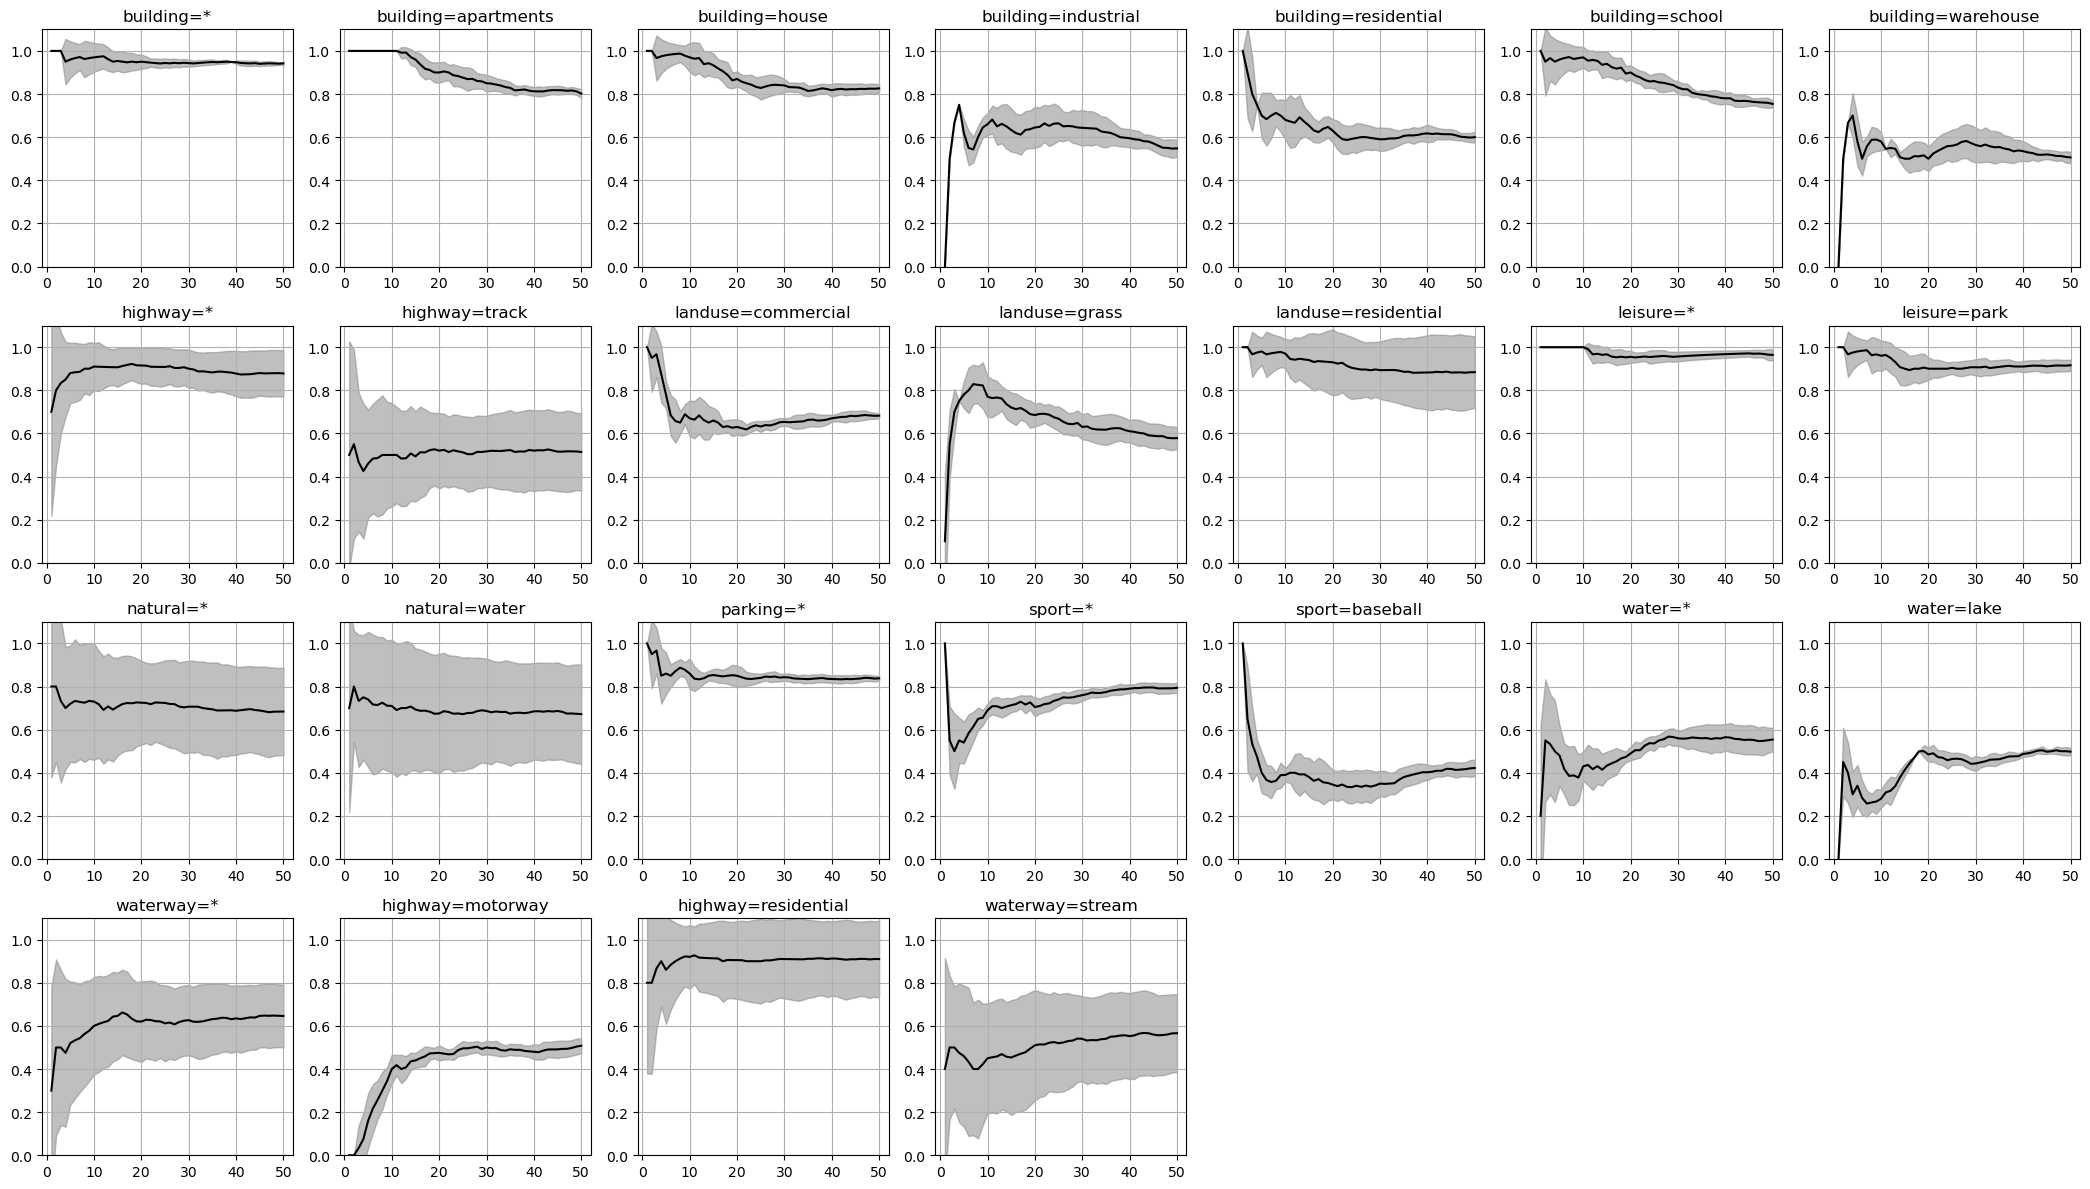

In [22]:
for ax, i in subplots(list(pr.keys()), n_cols=7):
    k = pd.DataFrame(pr[i])  
    pmeans = k.mean(axis=0).values
    pstds  = k.std(axis=0).values

    plt.plot(k.columns, pmeans, color="black")
    plt.fill_between(k.columns, pmeans-pstds, pmeans+pstds, color="gray", alpha=.5)
    plt.grid();
    plt.title(i)
    plt.ylim(0,1.1)
    plt.xlim(-1,52)

# define a user query

In [23]:
# select from these tags
searcher.model.osm_tags_names

array(['building=*', 'building=apartments', 'building=house',
       'building=industrial', 'building=residential', 'building=school',
       'building=warehouse', 'highway=*', 'highway=track',
       'landuse=commercial', 'landuse=grass', 'landuse=residential',
       'leisure=*', 'leisure=park', 'natural=*', 'natural=water',
       'parking=*', 'sport=*', 'sport=baseball', 'water=*', 'water=lake',
       'waterway=*', 'highway=motorway', 'highway=residential',
       'waterway=stream'], dtype='<U20')

In [24]:
chipm2 = 256*256*100 # how many square meters in a chip

In [25]:
tag_name_for_metric = np.random.choice(searcher.model.osm_tags_names)
tag_name_for_metric = 'highway=motorway'
tag_index_for_metric = np.argwhere(searcher.model.osm_tags_names==tag_name_for_metric)[0,0]
tag_name_for_metric, tag_index_for_metric

('highway=motorway', 22)

In [26]:
n_autocomplete_samples = 10
min_counts, max_counts = {}, {}
min_areas,  max_areas  = {tag_name_for_metric: .01*chipm2} ,{}

min_counts, max_counts = {tag_name_for_metric: 1}, {}
min_areas,  max_areas  = {} ,{}

# autocomplete the query by sampling osm vectors that comply with the user query


In [27]:
# autocomplete the query by sampling osm vectors that comply with the user query
q = autocompletion_sampler.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                                           min_areas = min_areas, max_areas = max_areas,
                                                           n_samples=n_autocomplete_samples)
print (f"sampled {len(q['indexes'])} osm vectors complying with the user query")

sampled 10 osm vectors complying with the user query


# inspect the sampled chips with which the user query has been autocompleted

min areas and min counts


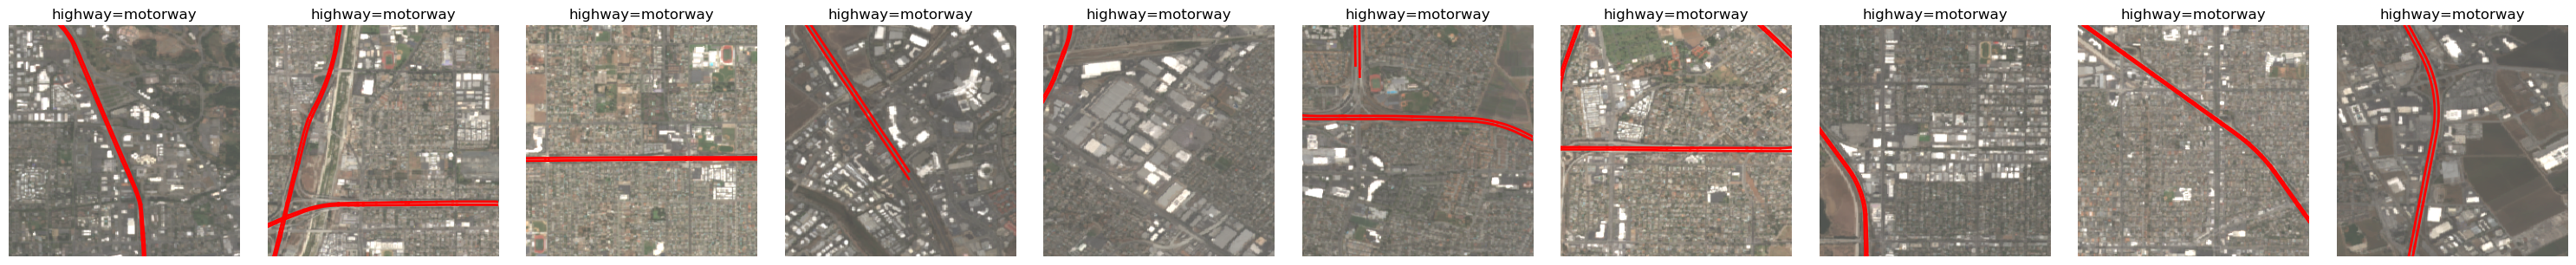

In [28]:
autocompletion_sampler.query_dataloader.dataset.disable_chip_loading = False
autocompletion_sampler.query_dataloader.dataset.reset_cache()

for tag in set(list(min_areas.keys()) + list(min_counts.keys())):
    for ax,qi in subplots(len(q['indexes'])):
        autocompletion_sampler.query_dataloader.dataset.plot_chip_with_tags(q['indexes'][qi], [tag])
        plt.title(tag)
print("min areas and min counts")

# build the osm vector for which to predict clay embeddings

mode can be

- `sample_autocompleted`: one random osm vector is selected from above
- `average_autocompleted`: the above osm vectors are averaged

note that the `osmencoder` expects osmvectors normalized (counts, areas and lengths substracted the distribution mean and divided by their stdev), so `query_osmvector` is normalized. we also store `query_original_osmcount` for visualization purposes only

In [29]:
query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
query_original_osmcount = q['original_query_vector']['osm_ohecount'].mean(axis=1)

# use the osmencoder to predict the clay embeddings

In [30]:
p = searcher.predict_embeddings(query_osmvector)[0]
p.shape

torch.Size([768])

# search for similar embeddings

- use `topn` to control how many results you get

In [31]:
r = searcher.make_search(p, topn=10)
print ("search results structure\n")

for k,v in r.items():
    if isinstance(v, np.ndarray):
        print (f"{k:10s}           {v.shape}")
    elif isinstance(v, dict):
        print (k)
        for kk,vv in v.items():
            print (f"     {kk:15s} {vv.shape}")            
        


search results structure

chip_ids             (10,)
normalized_osm_vectors
     osm_ohecount    (10, 99)
     osm_ohearea     (10, 99)
     osm_ohelength   (10, 99)
embeddings           (10, 768)
original_osm_vectors
     osm_ohecount    (10, 99)
     osm_ohearea     (10, 99)
     osm_ohelength   (10, 99)
idxs                 (10,)
scores               (10,)


# inspect search results

osm tags are painted in red only for validation purposes, those should not be available in a production environment

In [32]:
ds = searcher.get_search_dataset()
ds.disable_chip_loading = False
ds.reset_cache()


TAGS for min areas and min counts


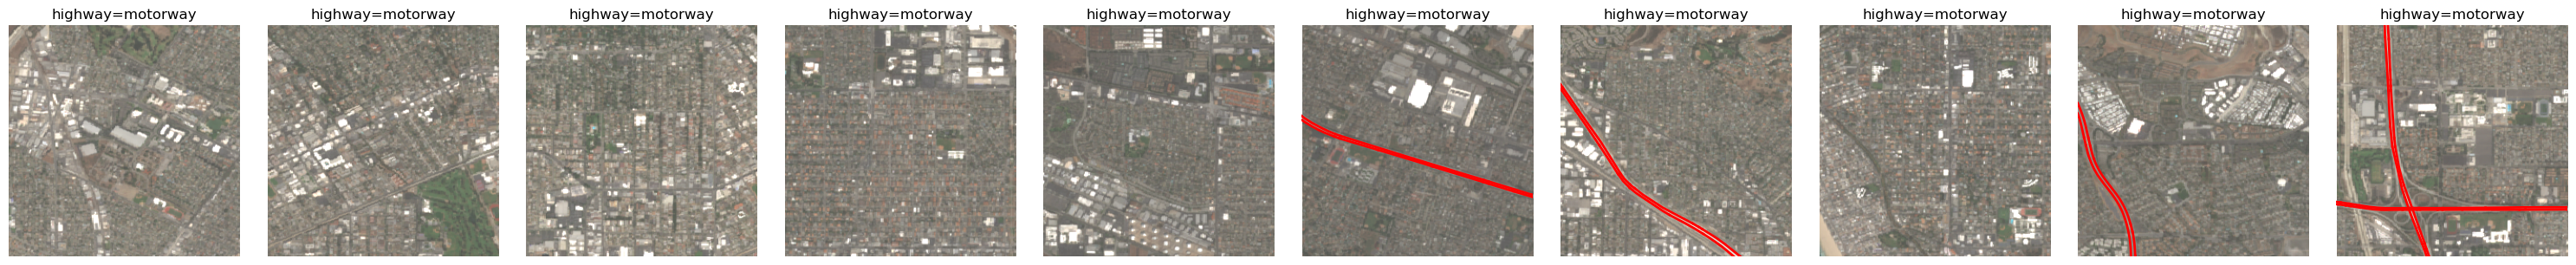

In [33]:
for tag in set(list(min_areas.keys()) + list(min_counts.keys())):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)
print ("TAGS for min areas and min counts")

In [34]:
for tag in list(max_areas.keys()) + list(max_counts.keys()):
    for ax, i in subplots(len(r['idxs'])):
        ds.plot_chip_with_tags(r['idxs'][i],  [tag])
        plt.title(tag)
print ("TAGS for max areas and ax counts")

TAGS for max areas and ax counts
